# Project DeepChef

## Food.com - Recipes and Reviews
### Data on over 500,000 recipes and 1,400,000 reviews from Food.com
Link to the dataset: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

## TO DO LIST
### 1. Data Processing and Cleaning
#### 1.1. Upgrade the recipes dataset with accurate ingredients info:
Many of the recipes suffer from one of the following: inaccurate ingredient-quants lists (e.g., from '1 1/2 cans of beans', 1 and 1/2 have been separated), inaccurate ingred-items lists (e.g., '2 spoons of butter or margrine' both butter and margrine have been sepearated and added to the relevant list). As a result of such mistakes, many mismatches occur between ingred_quants and ingred_items. Also measures are missing (lbs, teaspoon, cans, etc), so it's not clear what those quantities are measured with. Run the following codes to see an example: 

                        print('https://www.food.com/recipe/crunchy-peanut-biscuit-ring-18289')
                        print(recipes.iloc[14987]['RecipeIngredientQuantities'])
                        print(recipes.iloc[14987]['RecipeIngredientParts'])
I'm goling to fix these problems by following the procedures below:

- Scrape all the links and recipe ids by making Selemnium scroll through food.com/search as much as it takes.
- Loop through all links and extract original `ingredient_quants` and `ingredient_items` from the page (maybe also other things such as `picked_by`).
- Create a dataframe containing `link`, `RecipeID`, etc., and joing it with the Recipes dataset on `RecipeID`
- Drop the original `ingredient_quants` and `ingredient_items` from the Recipes dataset.
- <span style="color:red">**NOTE (June 18):**</span> This is being done in another Jupyter Notebook named `Scraping Food.com`.

#### 1.2. Deal with null values and duplicates - <span style="color:red"> (This is being done in another Jupyter notebook.)</span>
<span style="color:red">**Update (June 19):**</span>
- Several redundant columns were dropped andseveral others were created.
- `RecipeCategory` needs to be fractured into several subcategories.
- Several categories suffer from large amounts of null values. I'm thinking to use ML and predict the missing values for most of these, using the entries that have values assigned to the columns of interest. For this I need to figure what algorithms to use on which features to predict the missing values.
- I have to review Linear Regression and multicolinearity stuff for finding and dropping redundant columns.


### 2. EDA

### 3. Sentiment Analysis on Reviews

### 4. Predicting Ratings Based on Reviews and other Recipe Factors 

### 5. Recommender System

### 6. Topic Modeling and Cluster Analysis
- Cluster recipes based on their similarities.

### 7. Semantic Search (if time allows)

### 8. Recipe Generation (if time allows)
- As a starting point, you could consider using a smaller subset of your dataset, such as 10,000 to 20,000 recipes, to perform an initial fine-tuning. This subset should be diverse and representative of the different recipe types and variations you want your model to generate. (see https://chat.openai.com/share/254a1b63-9722-4ee4-ad13-1d6a82b251a1)

- I think I can select a diverse set of recipes based on the topics/clustered produced in Step 5

# Quick EDA

In [1]:
import sys
sys.executable

'C:\\Users\\mathe\\anaconda3\\envs\\deepchef\\python.exe'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
recipes = pd.read_parquet('recipes.parquet')

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
recipes.sample(2)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
60263,64621.0,Mediterranean Meatloaf,15718,Steve P.,PT45M,PT10M,PT55M,2003-06-16 20:05:00+00:00,A quick and easy to make meatloaf with a disti...,[],Lamb/Sheep,"[Meat, European, < 60 Mins, Oven]","[1 1⁄2, 2, 2, 1, 1, 1, 3, 1⁄2, 3]","[ground lamb, eggs, diced tomatoes, pitted bla...",4.5,3.0,564.2,33.7,13.0,153.3,1254.9,37.2,5.0,6.3,28.1,NaN,None,[In a large bowl combine all of the above ingr...
202243,211046.0,Italian Peas (Peas With Prosciutto),354465,MTpockets,PT15M,PT20M,PT35M,2007-02-12 23:11:00+00:00,An interesting blend of Orange zest and Prosci...,[],Vegetable,[< 60 Mins],"[1, 1⁄4, 1⁄2, 1, 1, 2, None]","[onion, orange zest, lettuce, prosciutto, butt...",NaN,NaN,75.8,2.2,1.2,5.0,93.2,10.8,3.1,4.2,3.8,NaN,None,"[In a medium saucepan, add water and cook peas..."


#### Adding recipe urls to the dataframe
We will use these links to scrape food.com in order to upgrade the ingredients

In [6]:
recipes['url']= recipes['Name'].apply(lambda x: x.replace(' ','-')+'-')
recipes['url']

0                        Low-Fat-Berry-Blue-Frozen-Dessert-
1                                                  Biryani-
2                                            Best-Lemonade-
3                           Carina's-Tofu-Vegetable-Kebabs-
4                                             Cabbage-Soup-
                                ...                        
522512                      Meg's-Fresh-Ginger-Gingerbread-
522513    Roast-Prime-Rib-au-Poivre-with-Mixed-Peppercorns-
522514                               Kirshwasser-Ice-Cream-
522515            Quick-&-Easy-Asian-Cucumber-Salmon-Rolls-
522516                             Spicy-Baked-Scotch-Eggs-
Name: url, Length: 522517, dtype: object

In [7]:
recipes['url'] = recipes[['url', 'RecipeId']].apply(lambda x: 'https://www.food.com/recipe/' + x['url'] + str(int(x['RecipeId'])), axis=1)
recipes['url']

0         https://www.food.com/recipe/Low-Fat-Berry-Blue...
1                    https://www.food.com/recipe/Biryani-39
2              https://www.food.com/recipe/Best-Lemonade-40
3         https://www.food.com/recipe/Carina's-Tofu-Vege...
4               https://www.food.com/recipe/Cabbage-Soup-42
                                ...                        
522512    https://www.food.com/recipe/Meg's-Fresh-Ginger...
522513    https://www.food.com/recipe/Roast-Prime-Rib-au...
522514    https://www.food.com/recipe/Kirshwasser-Ice-Cr...
522515    https://www.food.com/recipe/Quick-&-Easy-Asian...
522516    https://www.food.com/recipe/Spicy-Baked-Scotch...
Name: url, Length: 522517, dtype: object

In [38]:
#recipes['url_metric_measures'] = recipes['new_column'].apply(lambda x: x+ '?units=metric&scale=1')

In [8]:
recipes.sample(5)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url
373499,387010.0,Salsa Ranch Dressing,60992,Michelle S.,PT1H,PT5M,PT1H5M,2009-08-25 02:10:00+00:00,A little recipe I came up with for a Mexican i...,[],Salad Dressings,"[Low Protein, < 4 Hours, Easy]","[1⁄2, 1⁄2]",[salsa],NaN,NaN,156.6,15.6,2.4,8.1,481.4,3.4,0.6,2.1,0.9,NaN,None,"[Mix together well., Let set at least 1 hour f...",https://www.food.com/recipe/Salsa-Ranch-Dressi...
494078,512242.0,Weight Watchers Parmesan Crusted Chicken Schni...,242729,French Tart,PT25M,PT10M,PT35M,2014-01-17 14:32:00+00:00,This delectable low-calorie chicken dish is pa...,[https://img.sndimg.com/food/image/upload/w_55...,Lunch/Snacks,"[German, Austrian, Swiss, European, High Prote...","[2, 2, 2, 1, 1, None, None]","[boneless skinless chicken breasts, parmesan c...",4.5,5.0,218.6,5.3,1.7,79.9,318.3,11.9,1.0,1.0,29.2,2.0,2 Schnitzels,[Beat the chicken breasts with a mallet until ...,https://www.food.com/recipe/Weight-Watchers-Pa...
371522,384987.0,Healthy Couscous With Roasted Mediterranean Ve...,485109,Shuzbud,PT35M,PT5M,PT40M,2009-08-10 15:05:00+00:00,Compromising on calories shouldn't mean compro...,[https://img.sndimg.com/food/image/upload/w_55...,Lunch/Snacks,"[Onions, Peppers, Vegetable, European, Lactose...","[1, 2, 1, 1, 1, 1⁄2, 3⁄4, 1, None]","[olive oil, garlic cloves, red onion, yellow b...",5.0,5.0,467.7,8.2,1.3,0.0,308.8,83.0,7.1,4.3,15.7,NaN,None,"[Heat the oven to 350°F or 180°C., Put the oli...",https://www.food.com/recipe/Healthy-Couscous-W...
165638,173391.0,Ghrybe,293946,Creation In Hope,PT30M,PT30M,PT1H,2006-06-17 19:18:00+00:00,I am posting this for the Zaar World Tour II. ...,[],Dessert,"[Cookie & Brownie, Southwest Asia (middle East...","[2, 1, 1, 4, None]","[butter, confectioners' sugar, cake flour]",NaN,NaN,1619.9,93.3,58.5,244.0,656.8,186.8,2.3,79.8,12.2,NaN,None,[Place butter in mixing bowl and beat with ele...,https://www.food.com/recipe/Ghrybe-173391
174839,182858.0,Chicken Satay,329671,manushag,PT10M,PT1H,PT1H10M,2006-08-24 23:18:00+00:00,Make and share this Chicken Satay recipe from ...,[],Asian,"[High Protein, High In..., < 4 Hours]","[1, 2, 2, 2, 2, 1, 1, 1⁄2, 2, 1, 2, 1, 1]","[boneless chicken breast, garlic cloves, soy s...",NaN,NaN,438.9,29.2,6.0,72.6,901.4,13.9,3.0,7.3,33.1,4.0,None,[Mix all marinade ingredients together and add...,https://www.food.com/recipe/Chicken-Satay-182858


In [56]:
recipes.to_parquet('recipes_with_urls.parquet')
recipes.to_csv('recipes_with_urls.csv')

In [52]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   RecipeId                    522517 non-null  float64            
 1   Name                        522517 non-null  object             
 2   AuthorId                    522517 non-null  int32              
 3   AuthorName                  522517 non-null  object             
 4   CookTime                    439972 non-null  object             
 5   PrepTime                    522517 non-null  object             
 6   TotalTime                   522517 non-null  object             
 7   DatePublished               522517 non-null  datetime64[ns, UTC]
 8   Description                 522512 non-null  object             
 9   Images                      522516 non-null  object             
 10  RecipeCategory              521766 non-null 

In [10]:
category_counts = recipes['RecipeCategory'].value_counts()
cat_100  = category_counts.head(100)
cat_20 =  category_counts.head(20)

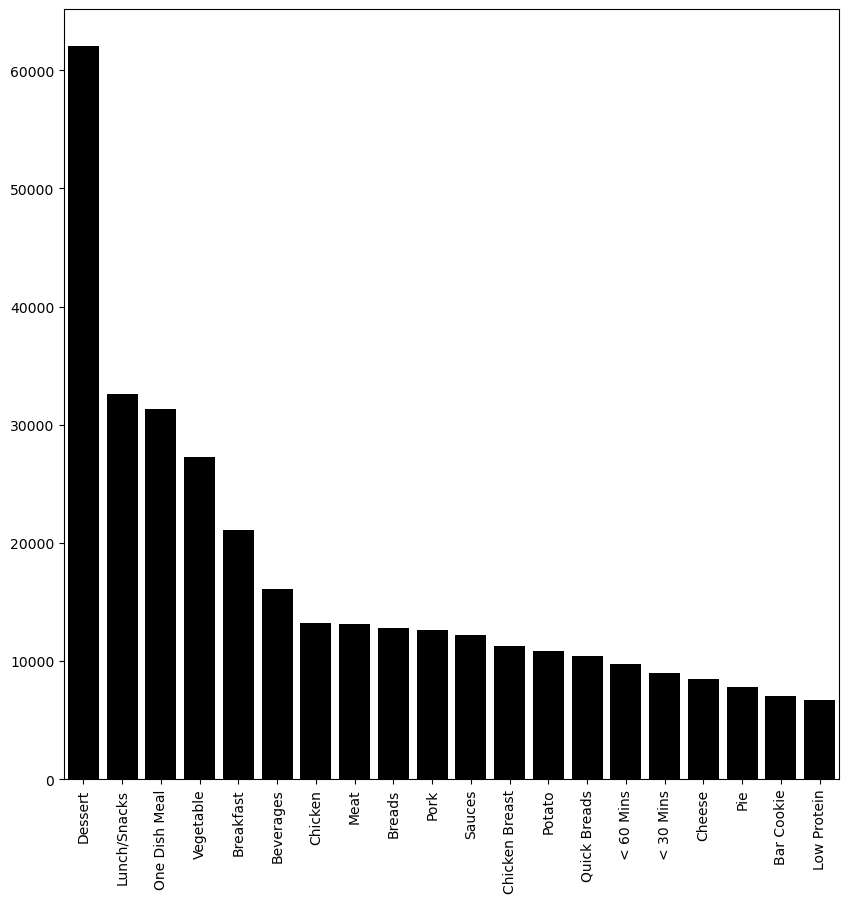

In [12]:
plt.figure(figsize=(10,10))
sns.barplot(x=cat_20.index,y=cat_20.values,color='black')
plt.xticks(rotation=90);

In [53]:
recipes.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


In [129]:
corr_matrix = recipes.corr(numeric_only=True)
corr_matrix

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
RecipeId,1.000000,0.255583,0.023619,-0.119984,-0.023472,-0.014328,-0.017066,-0.018130,-0.005429,-0.024014,0.000462,-0.023432,-0.008958,-0.000519
AuthorId,0.255583,1.000000,-0.010308,-0.009010,0.005596,0.005947,0.005721,0.011584,0.005012,0.000201,0.008555,-0.002163,0.012040,-0.001247
AggregatedRating,0.023619,-0.010308,1.000000,0.073092,0.000387,0.005001,0.004747,-0.000021,0.002568,-0.007359,-0.002710,0.000897,-0.003612,-0.006380
ReviewCount,-0.119984,-0.009010,0.073092,1.000000,-0.003243,-0.003157,-0.001894,-0.000957,0.003121,-0.002562,-0.009041,-0.002172,0.001927,0.000033
Calories,-0.023472,0.005596,0.000387,-0.003243,1.000000,0.855640,0.832771,0.619133,0.172558,0.615493,0.401384,0.564220,0.655283,-0.008513
FatContent,-0.014328,0.005947,0.005001,-0.003157,0.855640,1.000000,0.971745,0.653090,0.144270,0.133111,0.177042,0.097769,0.620247,-0.011762
SaturatedFatContent,-0.017066,0.005721,0.004747,-0.001894,0.832771,0.971745,1.000000,0.669179,0.131565,0.129995,0.185488,0.097426,0.618278,-0.010720
CholesterolContent,-0.018130,0.011584,-0.000021,-0.000957,0.619133,0.653090,0.669179,1.000000,0.119887,0.127749,0.086815,0.097906,0.707079,-0.006676
SodiumContent,-0.005429,0.005012,0.002568,0.003121,0.172558,0.144270,0.131565,0.119887,1.000000,0.099275,0.127017,0.071876,0.163967,-0.005363
CarbohydrateContent,-0.024014,0.000201,-0.007359,-0.002562,0.615493,0.133111,0.129995,0.127749,0.099275,1.000000,0.527203,0.960443,0.181894,-0.002962


<Axes: >

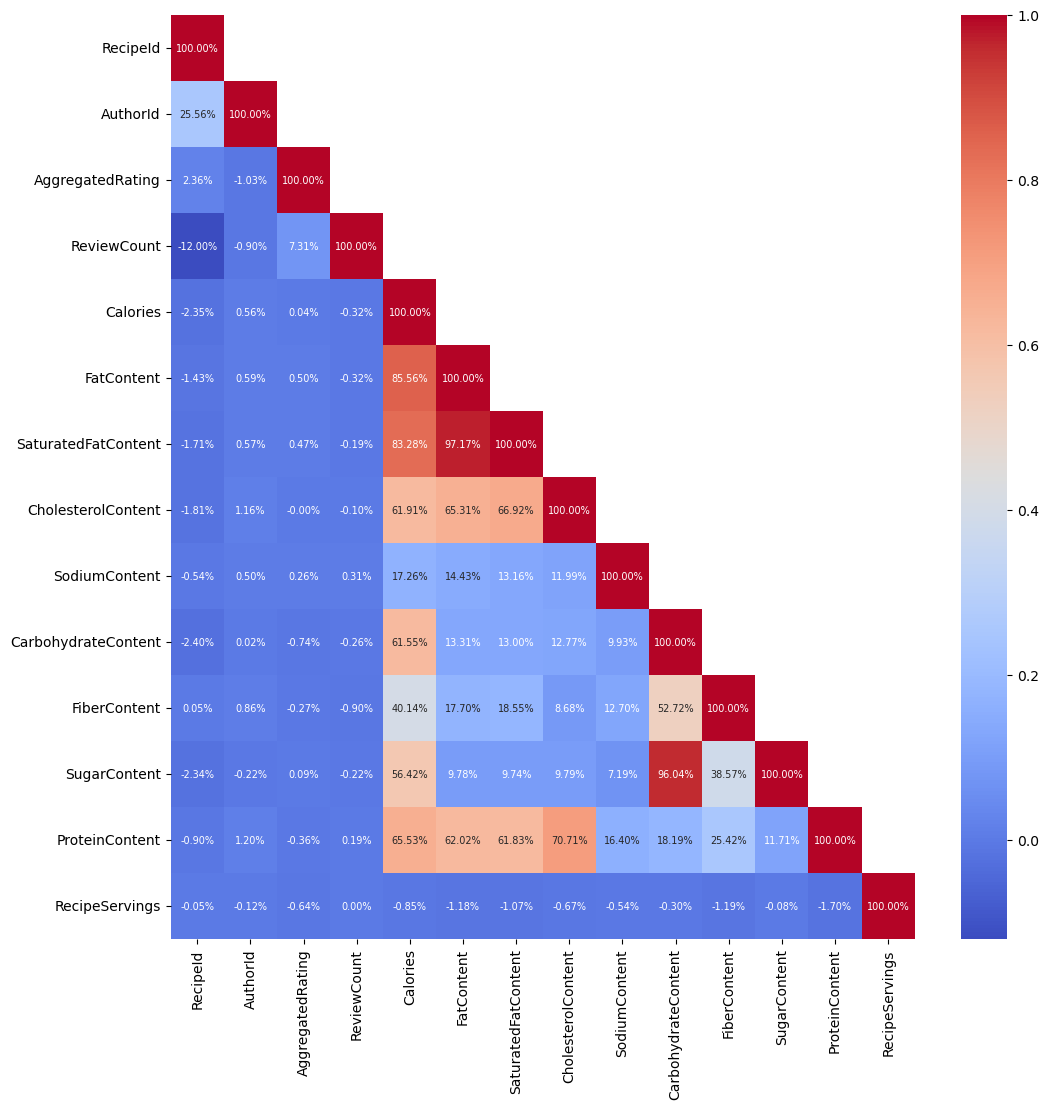

In [130]:
plt.figure(figsize=(12,12))

mask = ~np.tri(corr_matrix.shape[0], k=0, dtype=bool)
sns.heatmap(corr_matrix,cmap='coolwarm',mask=mask,annot=True,fmt=".2%",annot_kws={"fontsize": 7})

In [41]:
recipes.isna().sum()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

Let's do a quick Word Cloud:

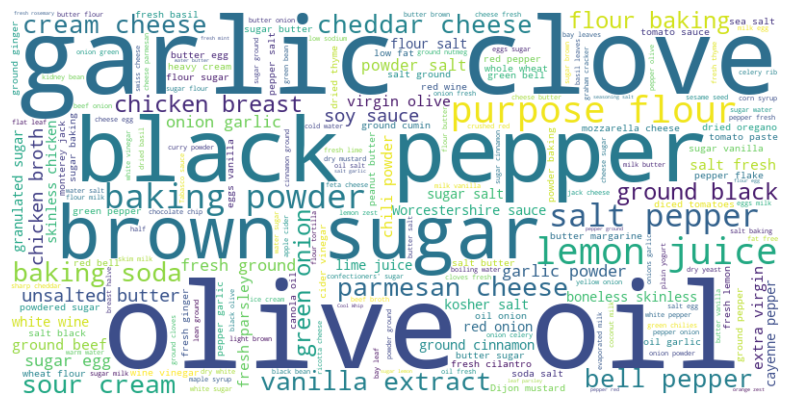

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Create an empty string to concatenate all ingredient lists
all_ingredients = ""

# Iterate over each row in the 'RecipeIngredientParts' column
for ingredients_list in recipes['RecipeIngredientParts']:
    # Join the ingredients list into a single string
    ingredients_string = ' '.join(ingredients_list)
    # Concatenate the string with all ingredients
    all_ingredients += " " + ingredients_string

# Generate the word cloud from all ingredients
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


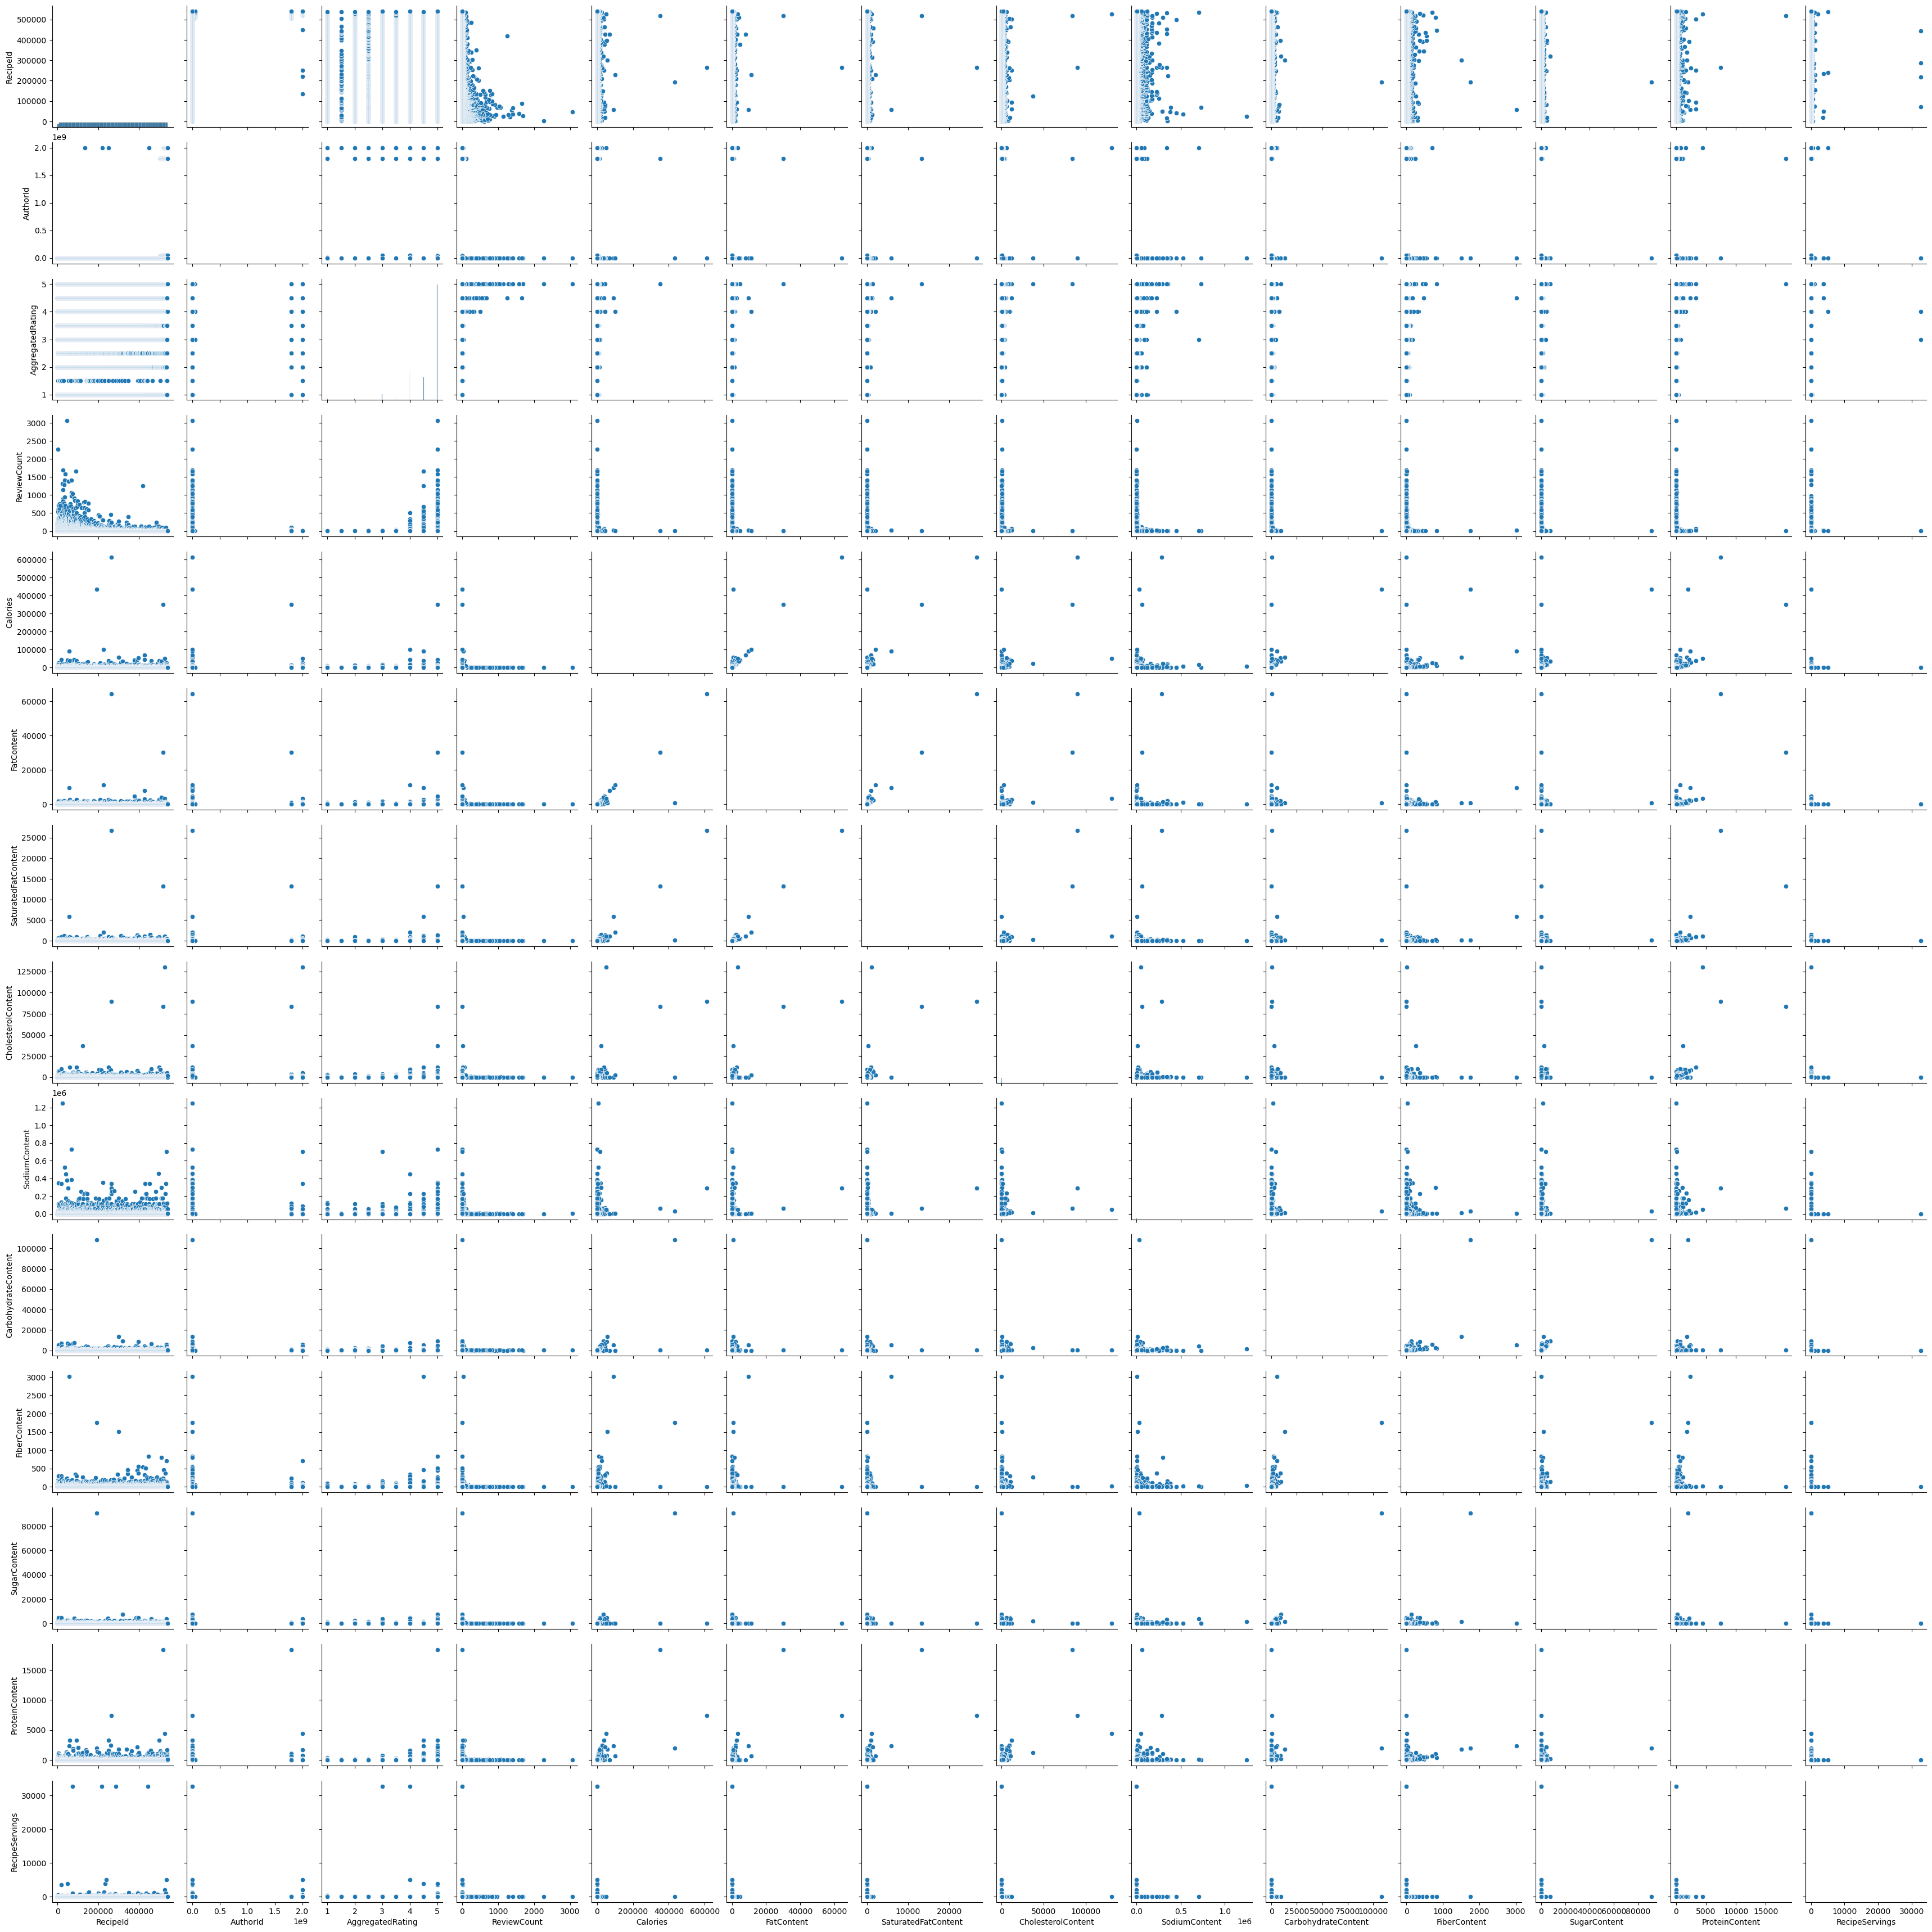

In [13]:
sns.pairplot(recipes)

## Reviews

In [11]:
reviews = pd.read_parquet('reviews.parquet')

In [12]:
reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25 21:44:00+00:00,2000-01-25 21:44:00+00:00
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17 16:49:59+00:00,2001-10-17 16:49:59+00:00
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00,2000-02-25 09:00:00+00:00
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00,2000-03-13 21:15:00+00:00
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28 12:51:00+00:00,2000-03-28 12:51:00+00:00


In [13]:
reviews['Review'].apply(lambda x: len(str(x))).sort_values(ascending=False)

175239     8587
1276789    6972
1279185    5799
1395693    5196
1355242    4954
           ... 
1353295       0
1342913       0
1355101       0
1378916       0
1378730       0
Name: Review, Length: 1401982, dtype: int64

In [14]:
reviews['Review'][1276789]

'I don&#039;t need to make this recipe myself to know that it&#039;s good because it&#039;s very similar to 1 that I first learned to make decades ago. I only gave it a 4 instead of a 5 because I know that I would prefer the saucier, veggie filled version that I have been making for years.&lt;br/&gt;&lt;br/&gt;This casserole is very similar to one that my family has been making for well over 20 years. My sister found the original recipe for a &quot;Chicken Num Num&quot; casserole in a magazine or from one of those subscription recipe collections. The Chicken Num Num recipe she found uses 1 can each of cream of Chicken and Cream of Mushroom soups, but no milk or broth to thin out the condensed soups, the 1/2 cup mayo, as well as 2 cans of french cut green beens, well drained. All of the shredded cheese is blended into the creamy chicken &amp; green been fillng, &amp; the biscuits are topped with finely crushed crakers. the Chicken Num Num recipe called for putting the biscuits onto the 